<a href="https://colab.research.google.com/github/evillag/TEC_DL_II-2022/blob/main/TP0/TP0_MaximaVerosimilitud_IBVOEV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curso de Aprendizaje Automático
# Trabajo Practico 0: Repaso de Probabilidades

**Escuela de Ingeniería en Computación | Instituto Tecnológico de Costa Rica**

Realizado por

*   Victoria Orozco
*   Ignacio Barquero
*   Esteban Villalobos

Fecha de entrega

* 11 de Setiembre de 2022

Entrega

* Un archivo .zip con el código fuente LaTeX o Lyx, el pdf, y un notebook en jupyter, debidamente documentado, con una función definida por ejercicio. A través del TEC-digital.

Modo de trabajo

* Grupos de 3 personas.

En el presente trabajo práctico se repasarán aspectos básicos del algebra
lineal, relacionados con los conceptos a desarrollar a lo largo del curso,
mezclando aspectos teóricos y prácticos, usando el lenguaje Python, con la
librería Pytorch.
________________________


In [71]:
%%capture

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import scipy.stats as stats

from torch.distributions import multivariate_normal
from sklearn.model_selection import ShuffleSplit
from mpl_toolkits.mplot3d import Axes3D

### Funciones multivariable
#### **El vector gradiente**: Para cada una de las siguientes funciones multivariable: grafique su superficie, calcule el vector gradiente manualmente,evaluelo y grafique el vector unitario o de largo conveniente para su visualización,en la dirección del gradiente para los dos puntos especificados(en la misma figura de la superficie). Finalmente calcule la magnitud 
de tal vector gradiente en cada punto.


In [72]:
def graph(x,y,z, p0, p1):
    ax = plt.axes(projection='3d')
    ax.plot_surface(x, y, z,cmap='viridis', edgecolor='none')
    ax.quiver(0,0,0, p0[0], p0[1], 0, color='r')
    ax.quiver(0,0,0, p1[0], p1[1], 0, color='b')
    ax.set_title('Surface plot')
    plt.show()

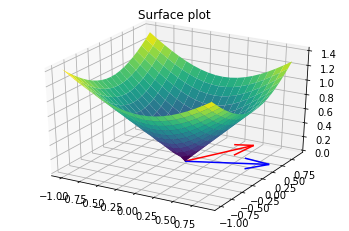

In [73]:
x = np.arange(-1, 1, 0.1)
x, y = np.meshgrid(x,x)
z = np.sqrt(np.square(x) + np.square(y))
graph(x,y,z,[0.4472,0.8944],[0.9145, 0.4045])

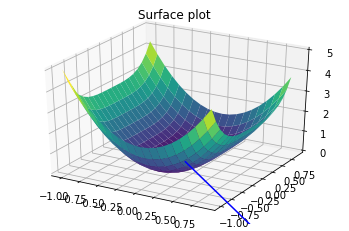

In [74]:
x = np.arange(-1, 1, 0.1)
x, y = np.meshgrid(x,x)
z = 3 * np.square(x) + 2 * np.power(y,4)
graph(x,y,z,[0,0],[7.4, -6.3])

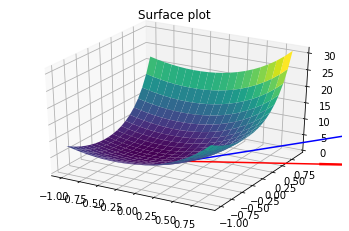

In [75]:
x = np.arange(-1, 1, 0.1)
x, y = np.meshgrid(x,x)
z = 4 * np.square(x) + 2 * x + np.power((np.exp(1)), 2 * x) + 5 * np.square(y) + np.power((np.exp(1)), 3 * y) + 1
graph(x,y,z,[2,1],[5, 7])

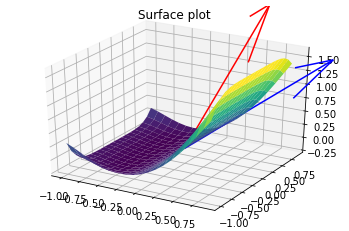

In [76]:
x = np.arange(-1, 1, 0.1)
x, y = np.meshgrid(x,x)
z = np.sin(np.square(x)) + x * np.cos(np.power(y , 3))
graph(x,y,z,[-2,6],[0, 4])

### Probabilidades: Algoritmo de Maximización de la Esperanza

#### 1.Implemente la función `generate_data` la cual reciba la cantidad de observaciones unidimensionales total a generar $N$, y los parámetros correspondientes a $K = 2$ funciones de densidad Gaussianas. Genere los datos siguiendo tales distribuciones, y retorne tal matriz de datos $X ∈ R^N$.


In [77]:
def generate_data(N = 10, K = 2, means = [3.0, 3.5], stds = [0.01, 0.01]):
    """Creates the data to be used for training, using a GMM distribution
    
    :param N: toltal number of observations
    :param K, the number of samples per class
    :param means: array of mean values for each class
    :param stds: array standard deviation values for each class
    """

    size = N//K
    samples = []  # [[1,2,3], [5,6,7]] -> [1,2,3,5,6,7]
    targets = []  # [[1,1,1], [2,2,2]] -> [1,1,1,2,2,2]
 
    for k in range(K):
      # Create Class k
      samples_k = create_data_class(torch.tensor(means[k]).float(),
                                    torch.tensor(stds[k]).float(), size)
      targets_k = torch.ones(1, size).squeeze().mul(k)
      samples.append(samples_k)
      targets.append(targets_k)

    # Concatenate all samples
    samples_all = torch.cat(tuple(sample for sample in samples), 0)
    # Concatenate all targets
    targets_all = torch.cat(tuple(target for target in targets), 0)    
    
    return targets_all, samples_all

def create_data_class(mean, std, n):
    """Creates data with gaussian distribution
    """

    # Inits the gaussian data generator
    normal_dist = torch.distributions.Normal(loc=mean, scale=std)
    
    # Create the samples
    gaussian_sample = normal_dist.sample((n,1)).squeeze()
    return gaussian_sample

def plot_data(dataX, dataY=None, label="Data", marker="o", show=True, title="",
              plot_pdf=True, mean = None, std = None):
    """Plot the given data. If the dataY is None, then it will 
    initialize it to a torch of zeros with the same shape as dataX.
    """

    if dataY is None:
      dataY = torch.zeros(dataX.shape)
    plt.scatter(dataX, dataY, label=label, marker=marker)
    plt.legend(loc="upper left")
    plt.title(title)
    if plot_pdf:
      mu = dataX.mean()
      sigma = dataX.std()
      
      if mean is not None:
        mu = mean
      if std is not None:
        sigma = std

      x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
      plt.plot(x, stats.norm.pdf(x, mu, sigma))

    if(show):
      plt.show()

Shape: torch.Size([10]).


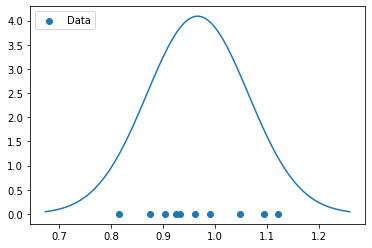

In [78]:
def test_data_class_creation():
  mu = 1.0
  std = 0.1
  n = 10
  samples = create_data_class(mu, std, n)
  assert samples.shape[0] == n
  assert  mu - std <=  samples.mean() <= mu + std
  print(f'Shape: {samples.shape}.')
  plot_data(samples)
  
test_data_class_creation()

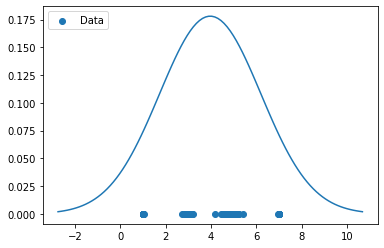

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])


In [79]:
def test_generate_data():
  targets, samples = generate_data(N=100, K=4, 
                                   means=[1.0, 3.0, 7.0, 5.0],
                                   stds=[0.01, 0.1, 0.01, 0.3])
  plot_data(samples)
  print(targets)

test_generate_data()

*a)* Grafique los datos usando un scatter plot junto con las gráficas de la función de densidad de probabilidad, en la misma figura (gráfico).

In [80]:
def plot_sample_data(samples_all, targets_all, K=2, means=None, stds=None,
                     show_separated=True, show_plot=True, title="", 
                     plot_pdf=True):
    """Plot data by class or whole data
    """

    if(show_separated):
      # Show data with labels and symbols
      for k in range(K):
        data_class = samples_all[targets_all==k]
        mean = None
        std = None
        
        if means is not None:
          mean = means[k]
        if stds is not None:
          std = stds[k]
        
        if k < K - 1:
          plot_data(dataX=data_class, label=f"Class {k} Samples", marker="x", 
                    show=False, plot_pdf=plot_pdf, mean=mean, std=std)
        else:
          plot_data(dataX=data_class, label=f"Class {k} Samples", 
                    show=show_plot, title=title, plot_pdf=plot_pdf)
    else:
      # Show whole data without labels and symbols
      plot_data(samples_all, label="Samples", show=show_plot, title=title)


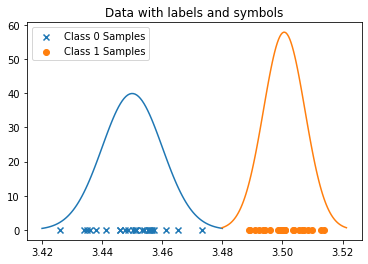

In [81]:
# Easy separation Data
means = [3.45, 3.5]
stds = [0.01, 0.01]
targets_all, samples_all = generate_data(N = 50, K = 2, means = means, 
                                         stds = stds) 

# Show data with labels and symbols
plot_sample_data(samples_all, targets_all, K=2, means = means, stds = stds, 
                 title="Data with labels and symbols")

#### 2.Implemente la función `init_random_parameters` la cual genere una matriz de $P ∈ R^{K×2}$ dimensiones, con los parámetros de las funciones de densidad Gaussiana generados completamente al azar.


##### a) Muestre un pantallazo donde verifique su funcionamiento correcto con los comentarios asociados.

**R/**La funcion `init_random_parameters` genera una matriz donde la primera columna es un vector de medias, y la segunda columna es un vector de desviaciones estandar. La matriz tiene K (clases) filas.

In [82]:
def init_random_parameters(k=2, mean_base=10):
  """Returns a K x 2 tensor with the parameters of the Gaussian distribution

  :param k: number of classes to generate params for.
  :return: A tensor of K x 2 dimensions of the form:

    [
      [mean_1, std_1],
      ...
      [mean_k, std_k]
    ]
  """
  means = torch.rand(k, 1).mul(mean_base)
  stds = torch.rand(k, 1)
  return torch.cat((means, stds), 1)


print(f"Random params:\n{init_random_parameters()}")
print(f"Random params:\n{init_random_parameters()}")
print(f"Random params:\n{init_random_parameters()}")
print(f"Random params:\n{init_random_parameters()}")

Random params:
tensor([[6.6715, 0.1169],
        [3.4396, 0.1328]])
Random params:
tensor([[8.5728, 0.0451],
        [6.1235, 0.3411]])
Random params:
tensor([[3.5096, 0.1520],
        [7.2516, 0.1985]])
Random params:
tensor([[8.9113, 0.3019],
        [8.6612, 0.5920]])


#### 3.Implemente la función `calculate_likelihood_gaussian_observation(x_n, mu_k, sigma_k)` la cual calcule la verosimilitud de una observación específica $x_n$, para una función de densidad Gaussiana con parámetros $μ_k$ y
$σ_k$.


##### a) Muestre un pantallazo donde verifique su funcionamiento correcto con los comentarios asociados.

R/ La función de densidad Gaussiana es un modelo con dos parámetros: la media $\mu$ y la dispersión $\sigma$. Para el caso donde $x\in\mathbb{R}$, se tiene que la función de densidad de probabilidad está dada por: 

\begin{equation}
f\left(x\right)=\mathcal{N}\left(x|\mu,\sigma\right)=\frac{1}{\sqrt{2\pi\sigma^{2}}}\exp\left(-\frac{1}{2\sigma^{2}}\left(x-\mu\right)^{2}\right)
\end{equation}

Sin embargo, existe el riesgo de caer en underflow, causado por multiplicar varios valores con magnitud menor a  $1$ , por lo que no se podría estimar correctamente la probabilidad de que las muestras pertenezcan a una clase o a la otra.

Para evitar este problema, se utiliza una transformación de logaritmo natural a la función de densidad de probabilidad; al ser el logaritmo una función monotónica-mente creciente, no contradice los máximos ni mínimos de la función original, por lo que no se altera el sentido de la maximización.

Al aplicar el logaritmo natural sobre la función de densidad de probabilidad, se tiene que la función para calcular el likelihood (ya simplificada) es:

\begin{equation}
ln(f(x))=ln\left(\mathcal{N}(x|\mu,\sigma)\right)=-\frac{1}{2}\left(ln{(2\pi)}\right)-ln{(\sigma)}-\frac{1}{2\sigma^{2}}(x-\mu)^{2}
\end{equation}

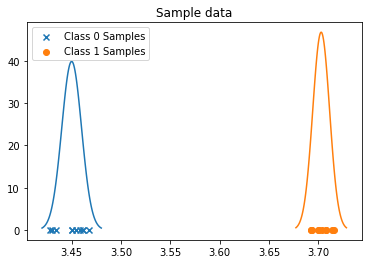

PDF class 0: mean 3.45, S.D 0.01
 tensor([   2.4748,    3.6848,    1.6541,    3.3372,    3.6029,    1.2413,
           2.2049,    3.6862,    3.0729,    3.0446, -308.4223, -328.3312,
        -309.4626, -316.9865, -349.7312, -328.7958, -293.4785, -291.2496,
        -344.6960, -289.4538])
PDF class 1: mean 3.7, S.D 0.01
 tensor([-348.9392, -307.4706, -361.2458, -288.2750, -298.6916, -366.5407,
        -267.2636, -309.0063, -281.7372, -281.1337,    3.6861,    3.3906,
           3.6859,    3.6335,    2.4279,    3.3766,    3.4933,    3.4323,
           2.7114,    3.3767])
Real classes
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])


In [83]:
import math

EPSILON = 0.00000001

def calculate_likelihood_gaussian_observation(x, mu_k, sigma_k):
  sigma_k += EPSILON  # avoid division by zero
  probs_vector = -0.5 * math.log(2*math.pi) - math.log(sigma_k) - 1/(2* math.pow(sigma_k, 2)) * (x - mu_k).pow(2)
  return probs_vector

means = [3.45, 3.7]
stds = [0.01, 0.01]
K = 2
targets_all, samples_all = generate_data(N = 20, K = K, means = means, 
                                         stds = stds) 
plot_sample_data(samples_all, targets_all, K=2, means = means, stds = stds, 
                 title="Sample data")

# print(f"samples_all:\n{samples_all}")
for k in range(K):
  print(f"PDF class {k}: mean {means[k]}, S.D {stds[k]}\n",
        calculate_likelihood_gaussian_observation(samples_all, means[k], stds[k]))

print("Real classes\n", targets_all)

#### 4.Implemente la función `calculate_membership_dataset(X_dataset, Parameters_matrix)`, la cual, usando la matriz de parámetros $P$ y la función anteriormente implementada `calculate_likelihood_gaussian_observation`, defina por cada observación $x_n ∈ X$ la pertenencia o membresía a cada cluster $k = 1,...K$, en una matriz binaria $M ∈ R^{N×K}$. Retorne tal matriz de membresía $M$.


##### a) Muestre un pantallazo donde verifique su funcionamiento correcto con los comentarios asociados.

In [84]:
def calculate_membership_dataset(X_dataset, Parameters_matrix):

  K = Parameters_matrix.shape[1]
  n = X_dataset.shape[0]
  membership_matrix = torch.zeros(n, K)
  probabilites_tensor = torch.zeros(n, K)
  
  k = 0
  for w in Parameters_matrix:
    mu_k = w[0]
    sigma_k = w[1]    
    cdf_vector = calculate_likelihood_gaussian_observation(
        X_dataset, mu_k, sigma_k)    
    probabilites_tensor[:, k] = cdf_vector
    k += 1

  # print(f"probabilites_tensor\n{probabilites_tensor.T}")

  for i in range(probabilites_tensor.shape[0]):
    # Choose the index of the highest value as the selected class
    probabilites_tensor[i,:].topk(1).indices[0]
    index = probabilites_tensor[i,:].topk(1).indices[0]
    membership_matrix[i,index] = 1

  return membership_matrix

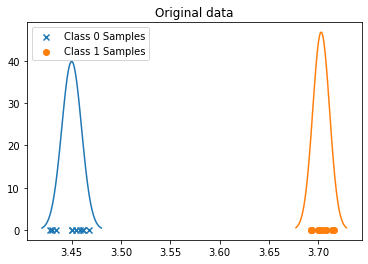

Sample: 
N = 20, K = 2.
Real means = [3.45, 3.7],
Real S.D. [0.01, 0.01]

Initial random parameters:
tensor([[0.0426, 0.7937],
        [8.2893, 0.4378]])
Calculate Membership dataset...
Resulting membership matrix M:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])


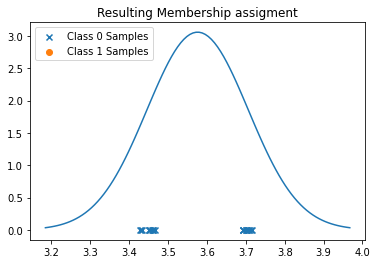

In [85]:
plot_sample_data(samples_all, targets_all, K=2, means = means, stds = stds, title="Original data")
w_random = init_random_parameters(2)
print('Sample: ')
print(f'N = {samples_all.shape[0]}, K = 2.\nReal means = {means},\nReal S.D. {stds}\n')
print(f'Initial random parameters:\n{w_random}')
print('Calculate Membership dataset...')
M = calculate_membership_dataset(samples_all, w_random)
print(f'Resulting membership matrix M:\n{M.T}')
predicted = torch.zeros(samples_all.shape)
predicted[M[:,1] == 1] = 1
plot_sample_data(samples_all, predicted, K=K, 
                 title=f"Resulting Membership assigment")

#### 5.Implemente la función `recalculate_parameters(X_dataset, Membership_data)`, la cual recalcule los parámetros de las funciones de densidad Gaussianas representandas en la matriz $P$, de acuerdo a lo representado en la matriz de membresía $M$.


##### a) Use las funciones `mean` y `std` de pytorch para ello. Intente prescindir al máximo de estructuras de repetición tipo `for`.

In [86]:
def recalculate_parameters(X_dataset, Membership_data):
  """ La funcion std de Pytorch se indefine si en el tensor resultante solo
  tiene un elemento, por ejemplo este tensor indefine el resultado de std:

  torch.tensor([1.0]).std() -> nan

  Por lo que se maneja este caso particular.

  """

  w = torch.zeros(Membership_data.shape[1], 2)  

  for k in range(Membership_data.shape[1]):
    class_data = X_dataset[Membership_data[:,k] == 1]
    if len(class_data) >= 1:
      w[k, 0] = class_data.mean()
      w[k, 1] = 0.0
      if len(class_data) > 1:
        w[k, 1] = class_data.std()
      
  return w


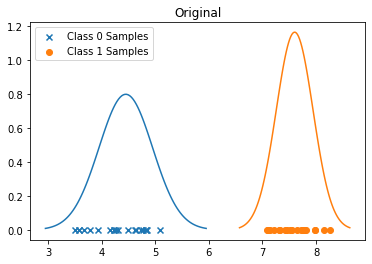

Real means = [4.45, 7.5], Real S.D. [0.5, 0.3]
Initial random parameters:
tensor([[3.1446, 0.2749],
        [4.6981, 0.4970]])
Recalculate parameters once...
New parameters:
tensor([[3.5766, 0.0722],
        [6.2170, 1.6081]])


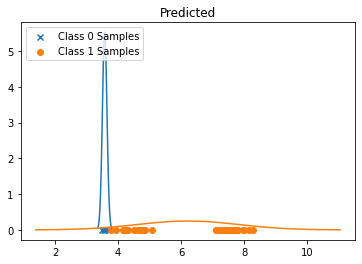

In [87]:
# test
means = [4.45, 7.5]
stds = [0.5, 0.3]
K = 2
targets_all, samples_all = generate_data(N = 40, K = K, means = means, 
                                         stds = stds) 
plot_sample_data(samples_all, targets_all, K=K, means = means, stds = stds, 
                 title=f"Original")

w_random = init_random_parameters(2, 10)
print(f'Real means = {means}, Real S.D. {stds}')
print(f'Initial random parameters:\n{w_random}')
M = calculate_membership_dataset(samples_all, w_random)
#print(f'M:\n{M.T}')
print("Recalculate parameters once...")
w = recalculate_parameters(samples_all, M)
print(f'New parameters:\n{w}')
predicted = torch.zeros(samples_all.shape)
predicted[M[:,1] == 1] = 1
plot_sample_data(samples_all, predicted, K=K, 
                 title=f"Predicted")


#### 6.Ejecute 5 corridas diferentes del algoritmo, donde por cada una documente los parámetros a los que se arribó.

##### a) Grafique las funciones de densidad de probabilidad a las que convergió el algoritmo. Puede graficar también las funciones de densidad obtenidas en 2 o 3 pasos intermedios.

In [88]:
means = [1.45, 12.5]
stds = [0.5, 0.3]
K = 2
targets_all, samples_all = generate_data(N = 500, K = K, means = means, 
                                         stds = stds)

In [89]:
def train(data, K = 2, interations = 5, w = None, show_intermediate = True):
  if w is None:
    w = init_random_parameters(K)
  print("Random parameters:\n", w)
  M = None
  predicted = torch.zeros(data.shape)

  for i in range(interations):
    # print(f"{i}-w: {w}")
    M = calculate_membership_dataset(data, w)
    # print(f"membership reassigned")
    w = recalculate_parameters(data, M)
    for k in range(K):
      predicted[M[:,k] == 1] = k
      if len(predicted[M[:,k] == 1]) == 0:
        break

    if show_intermediate and i in (1, 3):  # print every other iteration
      plot_sample_data(data, predicted, K=K, 
                       title=f"Iteration {i}: Predicted Data classes")

  plot_sample_data(data, predicted, K=K, 
                   title=f"Final: Predicted classes")
  return predicted, w

In [90]:
def run(run_id, samples, targets, k=2, interations = 5, w = None, 
        show_intermediate = True):
  print(f"Run #{run_id}")
  predicted, w_final = train(samples, k, interations, w, show_intermediate)
  plot_sample_data(samples, targets, K=K, means = means, stds = stds, 
                  title=f"Original classes")
  print(f"Predicted means: {w_final[:,0]}. Real means: {means}")
  print(f"Predicted variances: {w_final[:,1]}. Real variances: {stds}")
  print("w_final:\n", w_final)
  return predicted, w_final

Run #1
Random parameters:
 tensor([[3.5971, 0.9915],
        [1.8809, 0.2864]])


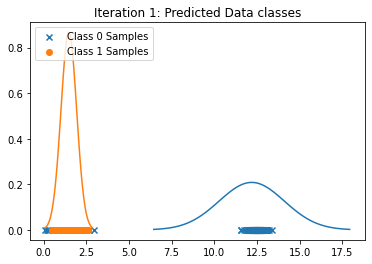

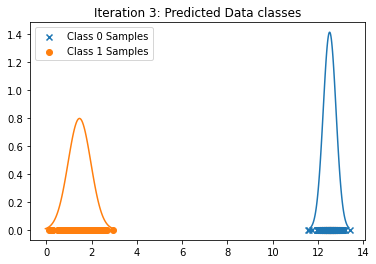

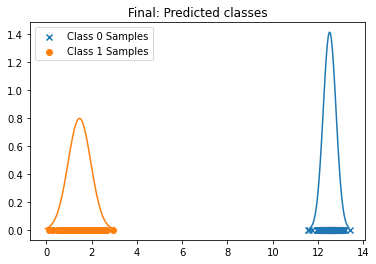

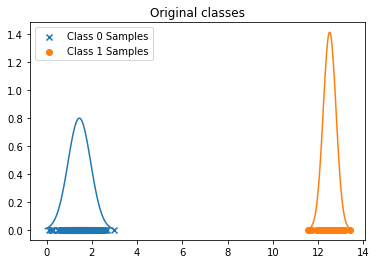

Predicted means: tensor([12.5120,  1.4629]). Real means: [1.45, 12.5]
Predicted variances: tensor([0.2826, 0.5013]). Real variances: [0.5, 0.3]
w_final:
 tensor([[12.5120,  0.2826],
        [ 1.4629,  0.5013]])


In [ ]:
_, _ = run(1, samples_all, targets_all)

Run #2
Random parameters:
 tensor([[6.0316, 0.0459],
        [5.7435, 0.8375]])


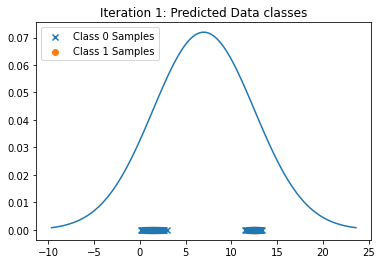

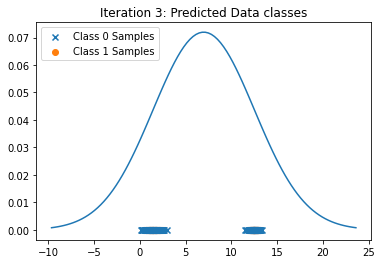

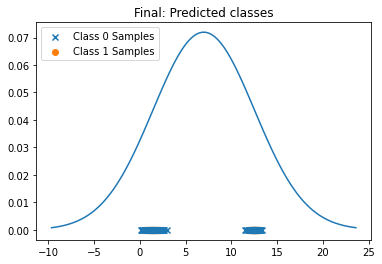

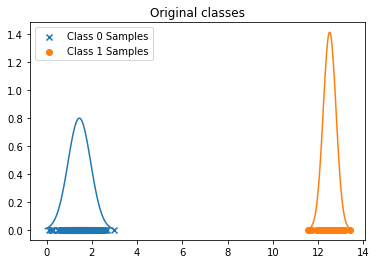

Predicted means: tensor([0.0000, 6.9874]). Real means: [1.45, 12.5]
Predicted variances: tensor([0.0000, 5.5450]). Real variances: [0.5, 0.3]
w_final:
 tensor([[0.0000, 0.0000],
        [6.9874, 5.5450]])


In [ ]:
_, _ = run(2, samples_all, targets_all)

Run #3
Random parameters:
 tensor([[0.7164, 0.2150],
        [9.2898, 0.3886]])


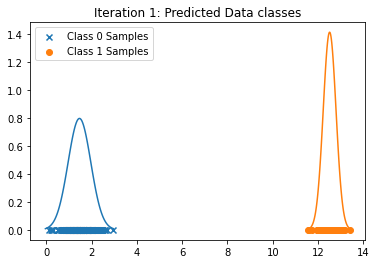

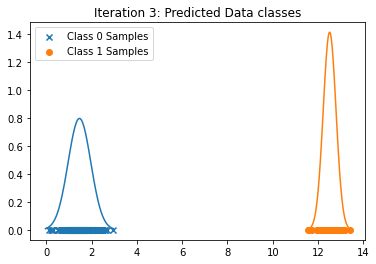

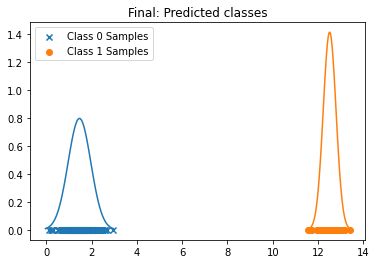

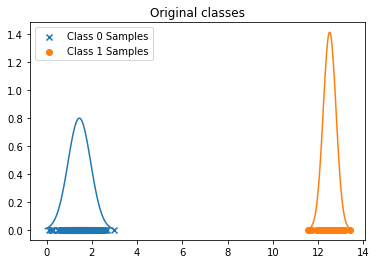

Predicted means: tensor([ 1.4629, 12.5120]). Real means: [1.45, 12.5]
Predicted variances: tensor([0.5013, 0.2826]). Real variances: [0.5, 0.3]
w_final:
 tensor([[ 1.4629,  0.5013],
        [12.5120,  0.2826]])


In [ ]:
_, _ = run(3, samples_all, targets_all)

Run #4
Random parameters:
 tensor([[9.1692, 0.6678],
        [1.4481, 0.5478]])


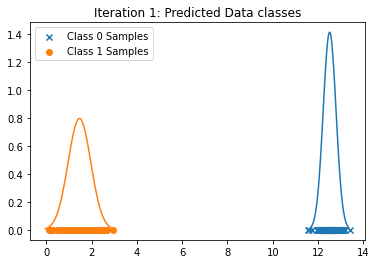

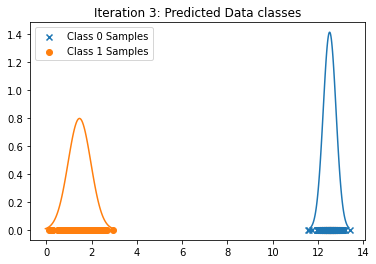

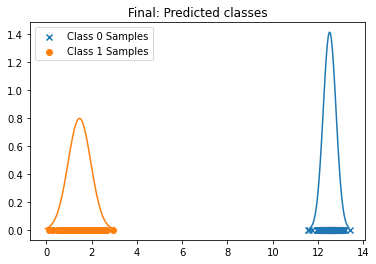

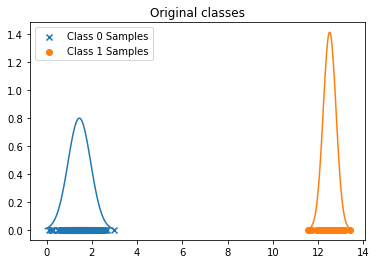

Predicted means: tensor([12.5120,  1.4629]). Real means: [1.45, 12.5]
Predicted variances: tensor([0.2826, 0.5013]). Real variances: [0.5, 0.3]
w_final:
 tensor([[12.5120,  0.2826],
        [ 1.4629,  0.5013]])


In [ ]:
_, _ = run(4, samples_all, targets_all)

Run #5
Random parameters:
 tensor([[7.5911, 0.0503],
        [0.4010, 0.4432]])


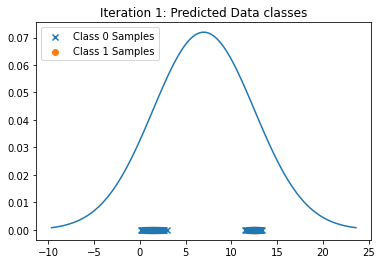

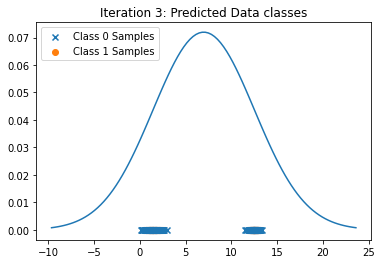

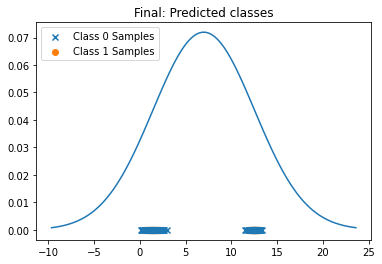

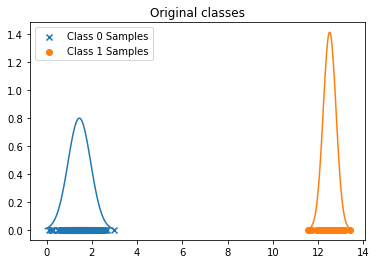

Predicted means: tensor([0.0000, 6.9874]). Real means: [1.45, 12.5]
Predicted variances: tensor([0.0000, 5.5450]). Real variances: [0.5, 0.3]
w_final:
 tensor([[0.0000, 0.0000],
        [6.9874, 5.5450]])


In [ ]:
_, _ = run(5, samples_all, targets_all)

##### b) Comente los resultados.

R/Se puede observar que el éxito o fracaso del algoritmo de maximización de la verosimilitud depende fuertemente en la selección inicial de los parámetros de la función de densidad de probabilidad utilizada, en este casos dichos parámetros están representados en la matriz $W$, y corresponden a la media y la desviación estándar iniciales para cada clase que estamos estimando.

Cuando estos valores están muy lejos de los valores reales, el algoritmo tiene a equivocarse. Con respecto a la medias aleatorias iniciales encontramos estos casos, cuando las desviaciones estándar son pequeñas:

a. Cuando las medias de todas las clases iniciales son casi iguales: en este caso el algoritmo parece clasificar todo (o una gran mayoría) dentro de una misma clase.

b. Cuando una o ambas medias aleatorias se estiman en el medio de toda la muestra, el algoritmo tiende a clasificar todo dentro de una misma clase.

c. Una media aleatoria es muy cercana a la media real de una clase y la otra media aleatoria es muy lejana a la media real de la otra clase: La clase cuya media real más cercana a la aleatoria original va a ser la predominante en la predicción.

La desviación estándar aleatoria inicial también afecta las predicciones, lo que hemos notado es que si la desviación estándar inicial es muy alta con respecto a la original, el "ancho" una de las "campanas" de una clase llega a cubrir valores pertenecientes a la otra clase, generando una predicción incorrecta.

Sin embargo, el tener una desviación estándar alta también causa beneficios en ciertos casos, porque puede llegar a clasificar valores en los percentiles mas altos y lejanos de una clase, corrigiendo hasta cierto punto, el problema cuando ambas medias originales son muy lejanas a las medias reales.

#### 7.Proponga una mejor heurística para inicializar los parámetros del modelo aleatoriamente. 

A la hora de realizar el entrenamiento, es posible examinar el conjunto de datos a priori, para obtener ciertas estadísticas y con ello tratar de tomar una mejor decisión con respecto a los valores iniciales de media y varianza de cada clase. 

Ya que la suma de dos variables aleatorias independientes con distribución normal, genera un conjunto que también sigue una distribución normal, es valido asumir que todo el conjunto de datos sigue dicho comportamiento. Si los datos de cada clase son separables y excluyentes entre sí, se podría asumir que se agrupan alrededor de percentiles diferentes dentro de la función de densidad de la distribución, es decir, existe una cantidad similar de valores a la izquierda de $\mu$ que a la derecha (ver las zonas en gris claro):

![image.png](https://as2.ftcdn.net/v2/jpg/01/21/75/91/1000_F_121759114_516gDhFvT9T5672E76wMc1I78JpsRlTM.jpg)

De manera que, en el caso de un conjunto con $2$ clases, se podría establecer de manera heurística para la clase 1: $\mu_1 = \mu-(\sigmaϵ)$; y para la clase 2: $\mu_2+(\sigmaϵ)$, donde $ϵ$ es un factor de escalamiento, y para la desviación estándar, se puede asignar $\frac{\sigma}{2}$ (donde $\sigma$ es el muestral) a las desviaciones estándard iniciales de cada clase. 


In [92]:
def estimate_initial_parameters(sample_data, e = 1.0):
  """This heuristic assumes that sample_data has two classes in it

    :param sample_data: sample dataset, assumes a 1-D torch
    :param e: scale factor.
    :returns: 2x2 torch where each row is the estimated mean and std for 
              each class.
  """
  
  mu = sample_data.mean()
  sigma = sample_data.std()
  mu_1 = mu - (sigma * e)
  mu_2 = mu + (sigma * e)
  return torch.tensor([[mu_1, sigma / 2], [mu_2, sigma / 2]])

In [ ]:
# test
means = [4.45, 7.5]
stds = [0.5, 0.3]
K = 2
targets_all, samples_all = generate_data(100, K, means = means, stds = stds)

In [ ]:
w_prime = estimate_initial_parameters(samples_all)
print(f'Clase 1: media estimada: {w_prime[0][0]}. Media real: {means[0]}. Delta = {means[0] - w_prime[0][0]}')
print(f'Clase 2: media estimada: {w_prime[1][0]}. Media real: {means[1]}. Delta = {means[1] - w_prime[1][0]}')
print(f'Std dev. estimada: {w_prime[0][1]}. Reales: {stds}. Delta: {stds[0]-w_prime[0][1]}, {stds[1]-w_prime[1][1]}')

Clase 1: media estimada: 4.5181427001953125. Media real: 4.45. Delta = -0.06814289093017578
Clase 2: media estimada: 7.535111427307129. Media real: 7.5. Delta = -0.035111427307128906
Std dev. estimada: 0.7542422413825989. Reales: [0.5, 0.3]. Delta: -0.2542422413825989, -0.4542422294616699


Como se puede observar en el ejemplo:

*Nota: Los datos son de una corrida anterior, no necesariamente son iguales a lo que muestra la celda anterior)*

Clase | μ real | μ estimada | Δ μ.   | σ real | σ estimada | Δσ |
------|--------|------------|--------|--------|------------|----|
1     | 4.45   | 4.5181     | -0.0681 | 0.5    | 0.7542     | -0.2542 |
2     | 7.50   | 7.7551     | -0.0351 | 0.3    | 0.7542     | -0.4542 |

Ambas medias fueron estimadas con un alto grado de precisión, claro, es un ejemplo de dos clases fácilmente separables. Las desviaciones estándard (S.D.) al ser calculadas arbitrariamente como la mitad de la S.D., si pueden presentar una diferencia mayor con respecto a las reales.

##### a) Compruebe la mejora obtenida con el método propuesto, corriendo las pruebas del punto anterior.

Para la prueba con los valores estimados con el heurístico **no** vale la pena repetir este experimento, pues los valores iniciales siempre van a ser los mismos para el mismo conjunto de datos con esta metodología.

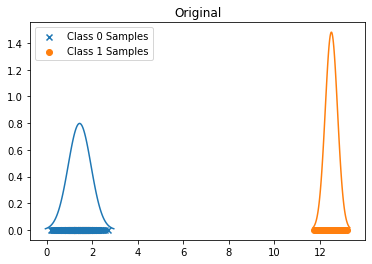

In [69]:
means = [1.45, 12.5]
stds = [0.5, 0.3]
K = 2
targets_all, samples_all = generate_data(N = 500, K = K, means = means, 
                                         stds = stds)
plot_sample_data(samples_all, targets_all, K=K, means = means, stds = stds, 
                 title=f"Original")

Run #1
Random parameters:
 tensor([[ 1.4369,  2.7723],
        [12.5260,  2.7723]])


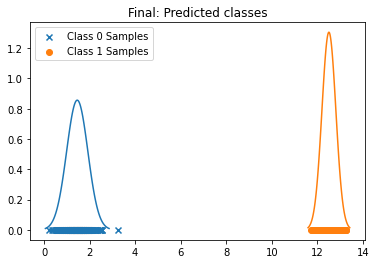

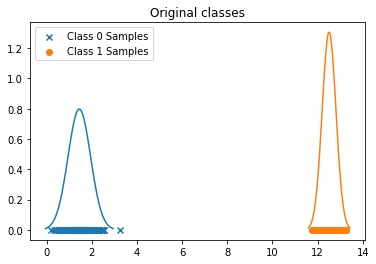

Predicted means: tensor([ 1.4564, 12.5065]). Real means: [1.45, 12.5]
Predicted variances: tensor([0.4657, 0.3056]). Real variances: [0.5, 0.3]
w_final:
 tensor([[ 1.4564,  0.4657],
        [12.5065,  0.3056]])


In [95]:
_, _ = run(1, samples_all, targets_all, w = estimate_initial_parameters(samples_all), 
    show_intermediate=False)

A continuación 5 corridas con el algoritmo heurístico, para conjuntos de datos diferentes, pero con clases separables.

Run #1
Random parameters:
 tensor([[3.1756, 0.9133],
        [6.8288, 0.9133]])


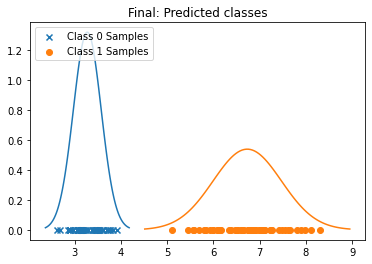

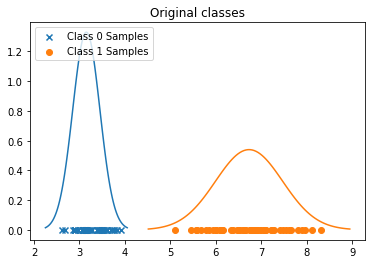

Predicted means: tensor([3.2727, 6.7316]). Real means: [3.15, 6.7]
Predicted variances: tensor([0.3017, 0.7389]). Real variances: [0.3, 0.7]
w_final:
 tensor([[3.2727, 0.3017],
        [6.7316, 0.7389]])
Run #2
Random parameters:
 tensor([[3.0859, 0.9145],
        [6.7441, 0.9145]])


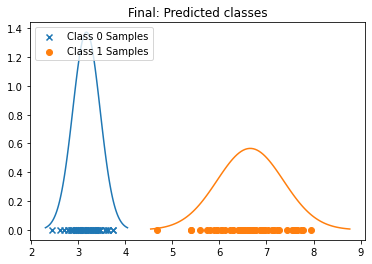

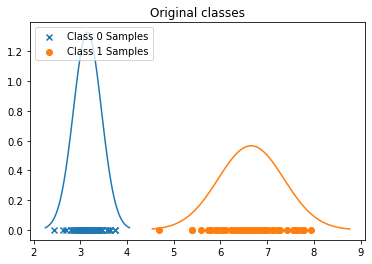

Predicted means: tensor([3.1751, 6.6549]). Real means: [3.15, 6.7]
Predicted variances: tensor([0.2906, 0.7050]). Real variances: [0.3, 0.7]
w_final:
 tensor([[3.1751, 0.2906],
        [6.6549, 0.7050]])
Run #3
Random parameters:
 tensor([[3.1144, 0.9478],
        [6.9056, 0.9478]])


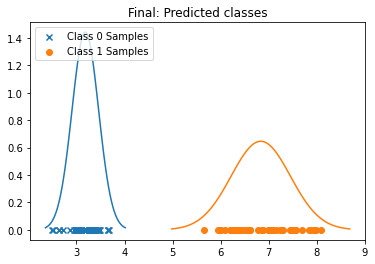

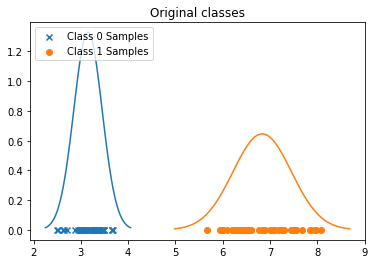

Predicted means: tensor([3.1844, 6.8356]). Real means: [3.15, 6.7]
Predicted variances: tensor([0.2768, 0.6175]). Real variances: [0.3, 0.7]
w_final:
 tensor([[3.1844, 0.2768],
        [6.8356, 0.6175]])
Run #4
Random parameters:
 tensor([[3.0102, 0.9487],
        [6.8050, 0.9487]])


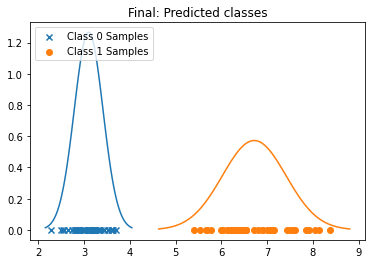

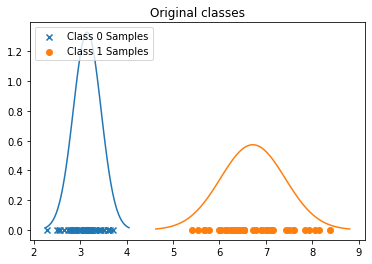

Predicted means: tensor([3.0971, 6.7181]). Real means: [3.15, 6.7]
Predicted variances: tensor([0.3149, 0.6965]). Real variances: [0.3, 0.7]
w_final:
 tensor([[3.0971, 0.3149],
        [6.7181, 0.6965]])
Run #5
Random parameters:
 tensor([[3.0515, 0.9200],
        [6.7313, 0.9200]])


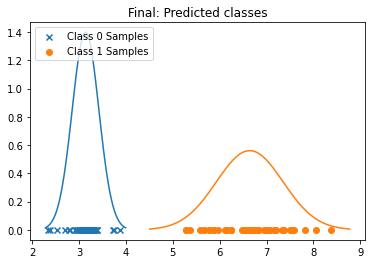

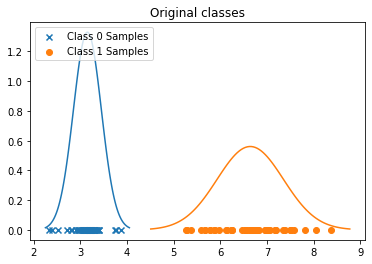

Predicted means: tensor([3.1410, 6.6417]). Real means: [3.15, 6.7]
Predicted variances: tensor([0.2851, 0.7112]). Real variances: [0.3, 0.7]
w_final:
 tensor([[3.1410, 0.2851],
        [6.6417, 0.7112]])


In [ ]:
means = [3.15, 6.7]
stds = [0.3, 0.7]
K = 2

for i in range(5):
  targets_all, samples_all = generate_data(100, K, means = means, stds = stds)
  run(i+1, samples_all, targets_all, 
      w = estimate_initial_parameters(samples_all), show_intermediate=False)

En este caso todas las corridas fueron existosas, aunque en algunas la S.D. no convirgió con la real, pero la clasificaición parece ser correcta.

A continuación una muestra de como clasifica el algorito original y el heurístico cuando los datos no son completamente separables.



In [ ]:
means = [6.15, 6.65]
stds = [0.5, 0.5]
K = 2
targets_all, samples_all = generate_data(100, K, means = means, stds = stds)

**Algoritmo Original**

Como se puede observar a continuación, la mayoría de las predicciones clasificó a todos los elementos en una clase, excepto la primera corrida.

Run #1
Random parameters:
 tensor([[2.0669, 0.2464],
        [2.2164, 0.0833]])


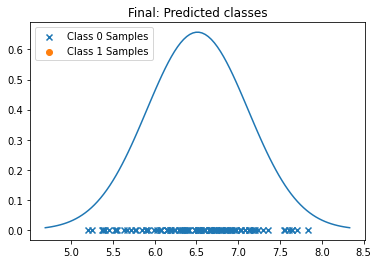

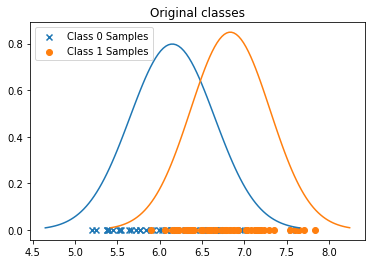

Predicted means: tensor([6.5118, 0.0000]). Real means: [6.15, 6.65]
Predicted variances: tensor([0.6068, 0.0000]). Real variances: [0.5, 0.5]
w_final:
 tensor([[6.5118, 0.6068],
        [0.0000, 0.0000]])
Run #2
Random parameters:
 tensor([[5.6707, 0.6738],
        [5.9274, 0.2367]])


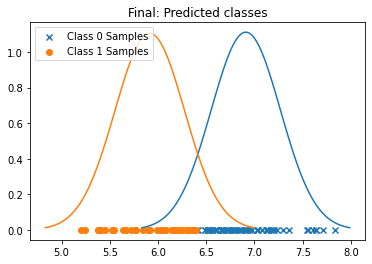

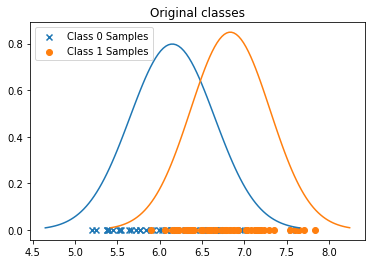

Predicted means: tensor([6.9100, 5.9146]). Real means: [6.15, 6.65]
Predicted variances: tensor([0.3588, 0.3609]). Real variances: [0.5, 0.5]
w_final:
 tensor([[6.9100, 0.3588],
        [5.9146, 0.3609]])
Run #3
Random parameters:
 tensor([[9.5671, 0.2892],
        [9.9067, 0.2385]])


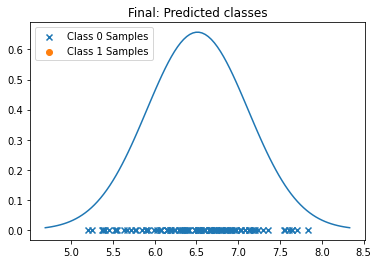

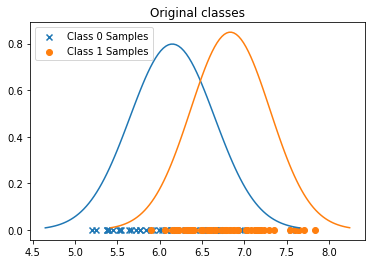

Predicted means: tensor([6.5118, 0.0000]). Real means: [6.15, 6.65]
Predicted variances: tensor([0.6068, 0.0000]). Real variances: [0.5, 0.5]
w_final:
 tensor([[6.5118, 0.6068],
        [0.0000, 0.0000]])
Run #4
Random parameters:
 tensor([[0.7069, 0.6278],
        [2.9618, 0.4958]])


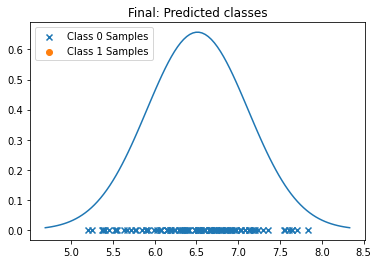

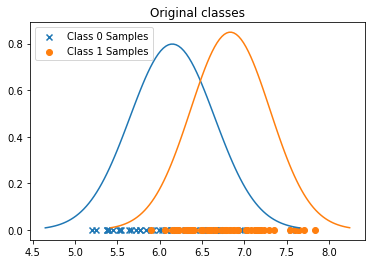

Predicted means: tensor([0.0000, 6.5118]). Real means: [6.15, 6.65]
Predicted variances: tensor([0.0000, 0.6068]). Real variances: [0.5, 0.5]
w_final:
 tensor([[0.0000, 0.0000],
        [6.5118, 0.6068]])
Run #5
Random parameters:
 tensor([[9.1380, 0.7252],
        [4.3139, 0.4378]])


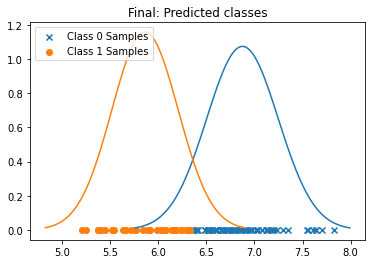

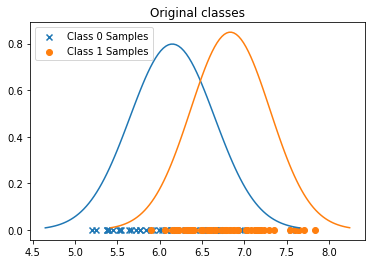

Predicted means: tensor([6.8761, 5.8642]). Real means: [6.15, 6.65]
Predicted variances: tensor([0.3715, 0.3449]). Real variances: [0.5, 0.5]
w_final:
 tensor([[6.8761, 0.3715],
        [5.8642, 0.3449]])


In [ ]:
for i in range(5):  
  _, _ = run(i+1, samples_all, targets_all, show_intermediate=False)

**Algoritmo Heurístico**

El algoritmo heurístico siempre va a realizar la clasificación que se ve a continuacíon, pues la inicialización original no es estocástica, sino calculada. En este caso se puede ver que presenta una mejor predicción, pues siempre va a poder determinar al menos la existencia de al menos dos clases, y va a ser consistente para cualquier corrida **en esta muestra.**

Run #1
Random parameters:
 tensor([[5.9050, 0.3034],
        [7.1186, 0.3034]])


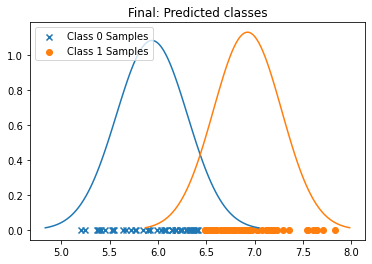

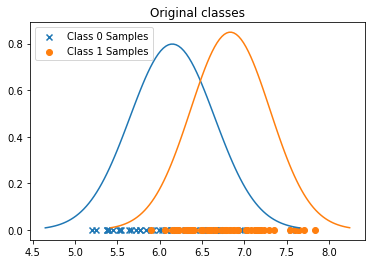

Predicted means: tensor([5.9381, 6.9273]). Real means: [6.15, 6.65]
Predicted variances: tensor([0.3677, 0.3523]). Real variances: [0.5, 0.5]
w_final:
 tensor([[5.9381, 0.3677],
        [6.9273, 0.3523]])


In [ ]:
_, _ = run(1, samples_all, targets_all, 
    w= estimate_initial_parameters(samples_all),
    show_intermediate=False)